[Hands on RL Policy Gradient](https://github.com/PacktPublishing/Hands-on-Reinforcement-Learning-with-PyTorch/blob/master/Section%204/4.3%20Policy%20Gradients%20REINFORCE.ipynb)<br>
[Policy Gradient Math](https://towardsdatascience.com/policy-gradients-in-reinforcement-learning-explained-ecec7df94245)<br>
[Vanilla Policy Gradient](https://spinningup.openai.com/en/latest/algorithms/vpg.html)<br>
[RL by Phil Tabor](https://github.com/philtabor/Youtube-Code-Repository/tree/master/ReinforcementLearning)

In [ ]:
#!pip install swig
#!pip install gymnasium[box2d]

## REINFORCE

![reinforce](reinforce.png) 

In [1]:
import os

import torch
from torch import cuda, device, distributions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from collections import deque

import gymnasium as gym
import os, random
from pathlib import Path
from collections import deque

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from IPython.display import clear_output

In [2]:
env_id = "LunarLander-v2"
env = gym.make(env_id)#,render_mode="human")

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  8
Sample observation [ 0.746006   -0.99026364  2.2653587   0.4100265   3.0626113   0.6999362
  0.25307024  0.32077134]


In [3]:
device = device("cuda:0" if cuda.is_available() else "cpu")

In [4]:
def calc_disc_return(r_t , gamma = 0.998):

    G_t = deque(maxlen = len(r_t))
    G_t.append(r_t[-1])

    for i in reversed(r_t[:-1]):
        disc = i + (gamma*G_t[0])
        G_t.appendleft(disc)

    return np.array(G_t)

class PolicyNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(PolicyNet, self).__init__()
        self.dense_layer_1 = nn.Linear(input_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return F.softmax(self.output(x),dim = 1)

class Agent():
    def __init__(self, state_size, action_size, hidden_size, gamma = 0.99, learning_rate = 0.001):
        
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.gamma = gamma
        
        self.policy_net = PolicyNet(state_size, action_size, hidden_size).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr = learning_rate)
    
    def train(self, states, rewards, actions):
        
        state_t = torch.FloatTensor(states).to(device)
        action_t = torch.LongTensor(actions).to(device).view(-1,1)
        return_t = torch.FloatTensor(calc_disc_return(rewards, self.gamma)).to(device).view(-1,1)

        eps = np.finfo(np.float32).eps.item()
        return_t = (return_t - return_t.mean()) / (return_t.std() + eps)
        
        action_prob = self.policy_net(state_t).gather(1, action_t)
        loss = torch.sum(-torch.log(action_prob) * return_t)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        grads = np.concatenate([p.grad.data.detach().cpu().numpy().flatten()
                                for p in self.policy_net.parameters()
                                if p.grad is not None])
        
        grad_l2 = np.sqrt(np.mean(np.square(grads)))
        grad_max = np.max(np.abs(grads))
    
        return loss.item(), grad_l2, grad_max
    
    def save(self, model_file):
        torch.save(self.policy_net.state_dict(), model_file)
        
    def load(self, model_file):
        self.policy_net.load_state_dict(torch.load(model_file))

In [5]:
hidden_layer = 64
gamma = 0.995
learning_rate = 0.001
episodes = 100_000
avg_win_size = 50
epi_results = deque(maxlen=avg_win_size)

agent = Agent(s_size, a_size, hidden_layer, gamma = gamma)

In [6]:
log_file_name = os.path.join('.','artefacts',f'{env_id}_policygradient.csv')
model_file = os.path.join('.','models',f'{env_id}_policygradient.pth')

In [7]:
train = False
if train:
    log_file = open(log_file_name, "w")
    log_file.write(f'episode,loss,rewards,l2_grad,max_grad\n')

for epi in range(episodes):

    if not train:
        print("set train flag to True for Training")
        break

    s = env.reset()[0]
    term , trunc = False, False
    rewards, states , actions = [], [], []
    win = 0

    while not any([term, trunc]):

        states.append(s)
        obs = torch.FloatTensor(np.expand_dims(s,0)).to(device)

        with torch.no_grad():
            p_vals = agent.policy_net(obs)
            p_vals = torch.squeeze(p_vals)

        p_vals = p_vals.detach().cpu().numpy()
        a = np.random.choice(a_size, p=p_vals)

        s_, r, term ,trunc, _  = env.step(a)
        actions.append(a)
        rewards.append(r)
        s=np.copy(s_)

    epi_results.append(np.sum(rewards))
    loss, grad_l2, grad_max = agent.train(states, rewards, actions)
    
    log_file.write(f'{epi},{loss:.2f},{np.sum(rewards):.2f},{grad_l2:.4f},{grad_max:.4f}\n')

    if epi%100==0:
        clear_output()
    if epi%10==0:
        print(f'epi:{epi:05d} reward:{np.sum(rewards):8.2f} loss:{loss:8.2f} mean_rewards:{np.mean(epi_results):8.2f}')
    if np.mean(np.mean(epi_results))>200:
        break

if train:
    print(f'Saving Agent as {model_file}')
    agent.save(model_file)
    log_file.close()

set train flag to True for Training


In [8]:
eval_agent = Agent(s_size, a_size, hidden_layer)
eval_agent.load(model_file)
df = pd.read_csv(log_file_name)
df['mean_rewards'] = df['rewards'].rolling(avg_win_size).mean()

Text(0.5, 1.0, 'Gradient')

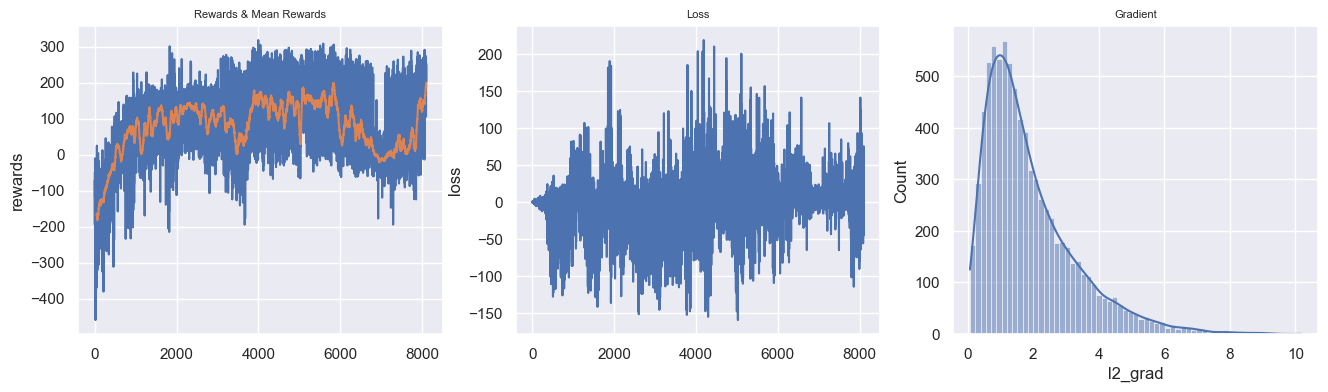

In [9]:
fig,ax=plt.subplots(1,3,sharex='col',sharey= False,figsize=(16,4))

sns.lineplot(df['rewards'], ax = ax[0])
sns.lineplot(df['mean_rewards'],ax = ax[0])
ax[0].set_title('Rewards & Mean Rewards',fontsize=8)

sns.lineplot(df['loss'],ax = ax[1])
ax[1].set_title('Loss',fontsize=8)
sns.histplot(df['l2_grad'],ax = ax[2], kde = True)
ax[2].set_title('Gradient',fontsize=8)

In [10]:
eval_env = gym.make(env_id,render_mode="human")

for epi in range(10):

    s = eval_env.reset()[0]
    term = False
    trunc = False
    score = 0
    n=0
    while not any([term, trunc]):

        obs = torch.FloatTensor(np.expand_dims(s,0)).to(device)

        with torch.no_grad():
            p_vals = eval_agent.policy_net(obs)
            p_vals = torch.squeeze(p_vals)

        p_vals = p_vals.detach().cpu().numpy()
        #a = np.random.choice(a_size, p=p_vals)
        a = np.argmax(p_vals)
        s, r, term ,trunc , _  = eval_env.step(a)
        #s = np.copy(s_)
        #env.render()
        n+=1
        score+=r
        if score >=200:
            break

    print(f'{epi = } result {score:4.2f}')
eval_env.close()

epi = 0 result 152.66
epi = 1 result 271.91
epi = 2 result 237.54
epi = 3 result 226.35
epi = 4 result 189.65
epi = 5 result 142.42
epi = 6 result 119.62
epi = 7 result 222.10
epi = 8 result 219.48
epi = 9 result 104.62
